In [1]:
import mlflow
import mlflow.sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("credit_risk_reto_processed.csv")

In [3]:
df.drop(columns=["Sex", "Prompt Length", "Prediction Mistral", "Loan Category", "Monthly_Payment"], inplace=True)
X = df.drop(columns=["Prediction Mistral Small"])
y = df["Prediction Mistral Small"]

In [4]:
string_columns = X.select_dtypes(include=["object"]).columns
X = pd.get_dummies(X, columns=string_columns)
X = X.sort_index(axis=1)

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [6]:
mlflow.set_experiment("Credit Risk")

2024/12/23 18:29:38 INFO mlflow.tracking.fluent: Experiment with name 'Credit Risk' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Files/Kaggle/Reevalua/mlruns/862650915588824870', creation_time=1734996578813, experiment_id='862650915588824870', last_update_time=1734996578813, lifecycle_stage='active', name='Credit Risk', tags={}>

Test Accuracy: 0.985
Confusion Matrix:
[[ 34   3]
 [  0 163]]
Classification Report:
              precision    recall  f1-score   support

         bad       1.00      0.92      0.96        37
        good       0.98      1.00      0.99       163

    accuracy                           0.98       200
   macro avg       0.99      0.96      0.97       200
weighted avg       0.99      0.98      0.98       200



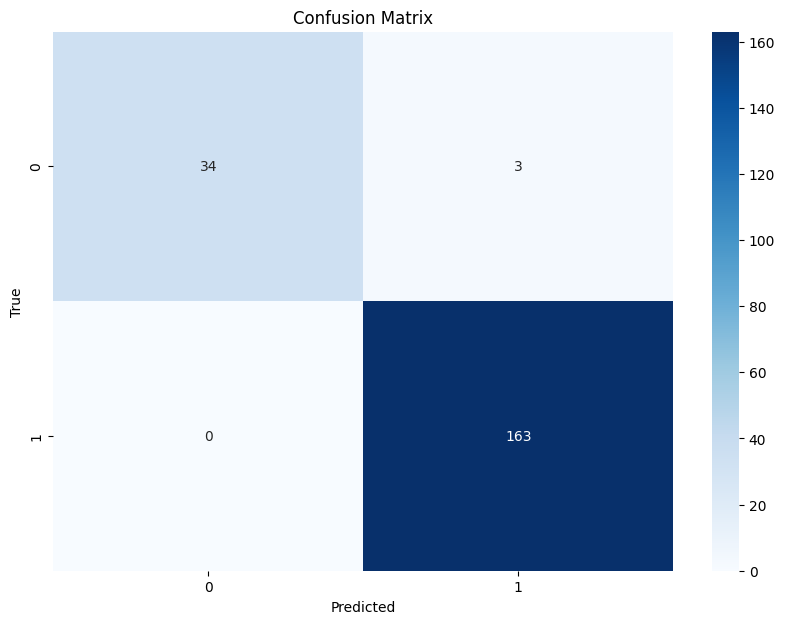

In [7]:
# Initialize the classifiers
clf1 = DecisionTreeClassifier(random_state=1)
# Define the parameter grid for DecisionTreeClassifier
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf1, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

# Start an MLflow run
with mlflow.start_run(run_name="DecisionTree_GridSearch"):
    # Fit GridSearchCV on the training data
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    clf1 = grid_search.best_estimator_

    # Log the best parameters
    mlflow.log_params(grid_search.best_params_)

    # Predict on the test data
    y_pred = clf1.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("accuracy", round(accuracy, 4))
    mlflow.log_metric("precision", round(report['weighted avg']['precision'], 4))
    mlflow.log_metric("recall", round(report['weighted avg']['recall'], 4))
    mlflow.log_metric("f1-score", round(report['weighted avg']['f1-score'], 4))

    # Log confusion matrix as an artifact
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    print(f"Test Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Test Accuracy: 0.995
Confusion Matrix:
[[ 36   1]
 [  0 163]]
Classification Report:
              precision    recall  f1-score   support

         bad       1.00      0.97      0.99        37
        good       0.99      1.00      1.00       163

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



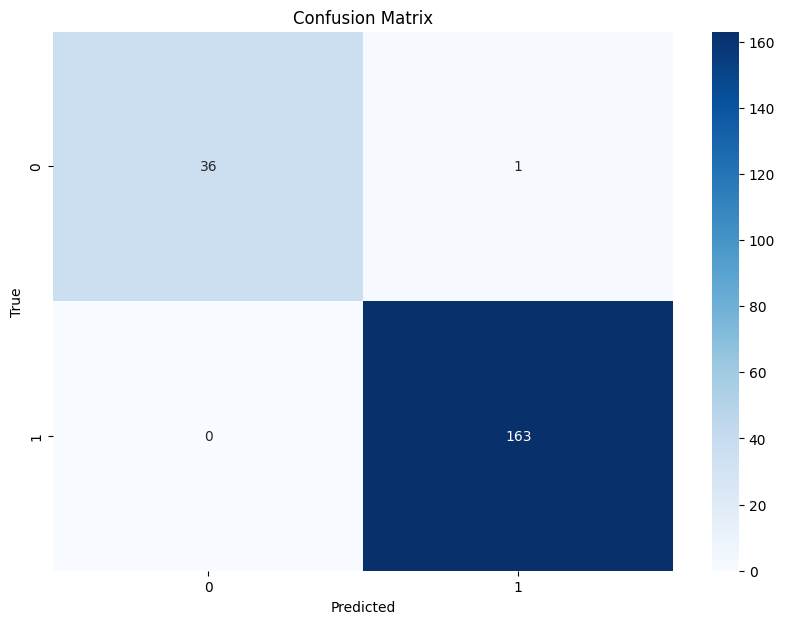

In [8]:
clf2 = lgb.LGBMClassifier(random_state=1, verbosity=-1)
# Define the parameter grid for LGBMClassifier
param_grid_lgb = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

# Initialize GridSearchCV for LGBMClassifier
grid_search_lgb = GridSearchCV(estimator=clf2, param_grid=param_grid_lgb, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search_lgb.fit(X_train, y_train)
# Start an MLflow run

with mlflow.start_run(run_name="LGBM_GridSearch"):
    # Fit GridSearchCV on the training data
    grid_search_lgb.fit(X_train, y_train)

    # Get the best estimator
    clf2 = grid_search_lgb.best_estimator_

    # Log the best parameters
    mlflow.log_params(grid_search_lgb.best_params_)

    # Predict on the test data
    y_pred = clf2.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", report['weighted avg']['precision'])
    mlflow.log_metric("recall", report['weighted avg']['recall'])
    mlflow.log_metric("f1-score", report['weighted avg']['f1-score'])

    # Log confusion matrix as an artifact
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix_lgb.png")
    mlflow.log_artifact("confusion_matrix_lgb.png")

    print(f"Test Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Test Accuracy: 0.995
Confusion Matrix:
[[ 36   1]
 [  0 163]]
Classification Report:
              precision    recall  f1-score   support

         bad       1.00      0.97      0.99        37
        good       0.99      1.00      1.00       163

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



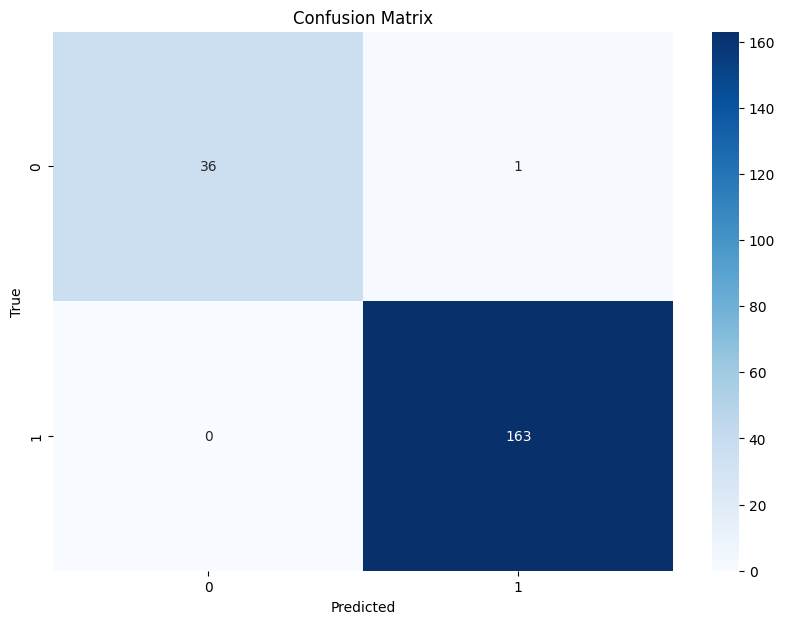

In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

clf3 = xgb.XGBClassifier(random_state=1)

# Define the parameter grid for XGBClassifier
param_grid_xgb = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

# Initialize GridSearchCV for XGBClassifier
grid_search_xgb = GridSearchCV(estimator=clf3, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search_xgb.fit(X_train, y_train_encoded)
# Start an MLflow run
with mlflow.start_run(run_name="XGB_GridSearch"):
    # Fit GridSearchCV on the training data
    grid_search_xgb.fit(X_train, y_train_encoded)

    # Get the best estimator
    clf3 = grid_search_xgb.best_estimator_

    # Log the best parameters
    mlflow.log_params(grid_search_xgb.best_params_)

    # Predict on the test data
    y_pred_encoded = clf3.predict(X_test)

    # Decode the predictions back to original labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("accuracy", round(accuracy, 4))
    mlflow.log_metric("precision", round(report['weighted avg']['precision'], 4))
    mlflow.log_metric("recall", round(report['weighted avg']['recall'], 4))
    mlflow.log_metric("f1-score", round(report['weighted avg']['f1-score'], 4))

    # Log confusion matrix as an artifact
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix_xgb.png")
    mlflow.log_artifact("confusion_matrix_xgb.png")

    print(f"Test Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Test Accuracy: 0.995
Confusion Matrix:
[[ 36   1]
 [  0 163]]
Classification Report:
              precision    recall  f1-score   support

         bad       1.00      0.97      0.99        37
        good       0.99      1.00      1.00       163

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



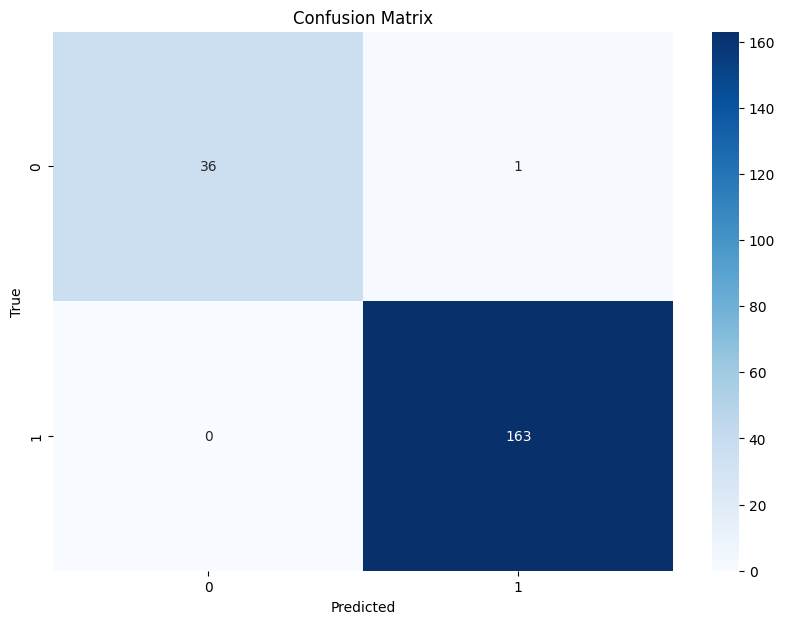

In [10]:
# Create a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('dt', clf1), 
    ('lgb', clf2), 
    ('xgb', clf3)], voting='soft')

# Start an MLflow run
with mlflow.start_run(run_name="VotingClassifier"):
    # Fit the VotingClassifier on the training data
    voting_clf.fit(X_train, y_train)

    # Predict on the test data
    y_pred = voting_clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("accuracy", round(accuracy, 4))
    mlflow.log_metric("precision", round(report['weighted avg']['precision'], 4))
    mlflow.log_metric("recall", round(report['weighted avg']['recall'], 4))
    mlflow.log_metric("f1-score", round(report['weighted avg']['f1-score'], 4))

    # Log confusion matrix as an artifact
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix_voting.png")
    mlflow.log_artifact("confusion_matrix_voting.png")

    print(f"Test Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))